# Adversarial Debiasing
Adversarial Debiasing is an in-processing fairness algorithm that uses adversarial learning techniques to remove unwanted correlations between predictions and sensitive attributes.

This algorithm was introduced by Zhang et al. (2018) and employs a two-network architecture:
1. A **predictor network** that learns to predict the target variable
2. An **adversary network** that attempts to predict the sensitive attribute from the predictor's output

The key idea is to train these networks in an adversarial manner:
- The predictor tries to maximize prediction accuracy while minimizing the adversary's ability to predict the sensitive attribute
- The adversary tries to predict the sensitive attribute from the predictor's output
- A gradient reversal layer between the networks ensures that the predictor learns to make predictions that are both accurate and unbiased with respect to the sensitive attribute

The strength of the fairness constraint is controlled by a parameter lambda (adversary weight), where:
- lambda = 0: No fairness constraint (standard model)
- lambda > 0: Increasing values enforce stronger fairness constraints

In [1]:
import sys
import os

# Add the project's main directory to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..')))


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import openml

from fairlib import DataFrame
from fairlib.inprocessing import AdversarialDebiasing
from fairlib.metrics import statistical_parity_difference, disparate_impact

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Loading and Preparing the Adult Dataset
We'll use the Adult dataset from OpenML, which contains demographic information and predicts whether an individual earns more than $50K per year.

In [3]:
# Load the Adult dataset
adult_dataset = openml.datasets.get_dataset(179)
adult_X, _, _, _ = adult_dataset.get_data(dataset_format="dataframe")

# Rename the target column
adult_X.rename(columns={'class': 'income'}, inplace=True)

# Convert to fairlib DataFrame
adult = DataFrame(adult_X)

# Set target and sensitive attributes
adult.targets = 'income'
adult.sensitive = ['sex']

# Preprocess the dataset
adult.drop(columns=["fnlwgt"], inplace=True)

label_maps = {}

for col in adult.columns:
    if adult[col].dtype == 'object' or adult[col].dtype == 'category':
        adult[col], uniques = pd.factorize(adult[col])
        label_maps[col] = uniques

# Display dataset info
print(f"Dataset shape: {adult.shape}")
print(f"Target column: {adult.targets}")
print(f"Sensitive attributes: {adult.sensitive}")

# Display first few rows
adult.head()

Dataset shape: (48842, 14)
Target column: {'income'}
Sensitive attributes: {'sex'}


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,income
0,0,0,0,13,0,0,0,0,0,0,0,0,0,0
1,1,1,0,13,1,1,1,0,0,1,0,1,0,0
2,0,2,1,9,2,2,0,0,0,1,0,0,0,0
3,1,2,2,7,1,2,1,1,0,1,0,0,0,0
4,2,2,0,13,1,3,2,1,1,1,0,0,1,0


## Exploring the Dataset
Let's examine the distribution of the target variable across different demographic groups to identify potential bias.

<Figure size 1000x600 with 0 Axes>

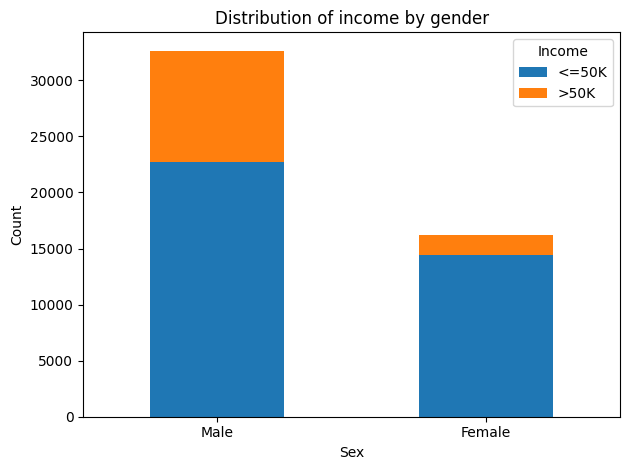

In [4]:
sex_labels = label_maps['sex'].tolist()
income_labels = label_maps['income'].tolist()

# Calculate the sex/income cross distribution.
counts = adult.groupby('sex')['income'].value_counts().unstack()

# Rename indexes and columns to make them readable
counts.index = [sex_labels[i] for i in counts.index]
counts.columns = [income_labels[i] for i in counts.columns]

# Plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True)
plt.title('Distribution of income by gender')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Income')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Already from this plot it is possible to identify a significant disparity within the data.

## Preparing Data for Modeling
Let's prepare the data for modeling by encoding categorical variables and splitting into training and testing sets.

In [5]:
adult_encoded = adult.copy()

adult_encoded = adult_encoded[:1000]

# Split features and target
X = adult_encoded.drop(columns=['income'])
y = adult_encoded['income']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (700, 13)
Testing set shape: (300, 13)


## Training a Baseline Model
First, let's train a baseline model without any fairness interventions.

In [7]:
SENSITIVE_COL_NAME = "sex"

X_train_dataframe = DataFrame(X_train)
X_train_dataframe.sensitive = SENSITIVE_COL_NAME

baseline_model = AdversarialDebiasing(
    input_dim=X_train.shape[1],
    hidden_dim=8,
    output_dim=1,
    sensitive_dim=1,
    lambda_adv=0,
)
# Fit the model
baseline_model.fit(X_train, y_train)

X_test_dataframe = DataFrame(X_test)
X_test_dataframe.sensitive = SENSITIVE_COL_NAME

y_pred_tensor = baseline_model.predict(X_test)

y_pred_baseline = y_pred_tensor.detach().cpu().numpy()

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline model accuracy: {baseline_accuracy:.4f}")

baseline_spd = statistical_parity_difference(y_pred_baseline, X_test_dataframe[SENSITIVE_COL_NAME])
baseline_di = disparate_impact(y_pred_baseline, X_test_dataframe[SENSITIVE_COL_NAME])

# Print the fairness metrics
print(f"Baseline model accuracy: {baseline_accuracy}")
print(f"Statistical Parity Difference (SPD): {baseline_spd}")
print(f"Disparate Impact (DI): {baseline_di}")

Baseline model accuracy: 0.8233
Baseline model accuracy: 0.8233333333333334
Statistical Parity Difference (SPD): [[-0.15416163  0.15416163]
 [ 0.15416163 -0.15416163]]
Disparate Impact (DI): [[1.19766736 0.29957   ]
 [0.83495637 3.33811802]]


## Training Models with Different Adversary Weights
Now, let's train models with different adversary weights to see how the fairness-accuracy trade-off changes.

In [10]:
adv_weights = [0.1, 0.5, 1.0]
results = {"lambda_adv": [], "accuracy": [], "SPD": [], "DI": []}

for lam in adv_weights:
    X_tr = DataFrame(X_train)
    X_tr.sensitive = SENSITIVE_COL_NAME
    X_te = DataFrame(X_test)
    X_te.sensitive = SENSITIVE_COL_NAME

    model = AdversarialDebiasing(
        input_dim=X_train.shape[1],
        hidden_dim=8,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=lam,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = y_pred.detach().cpu().numpy()

    acc = accuracy_score(y_test, y_pred)
    spd = statistical_parity_difference(y_pred, X_te[SENSITIVE_COL_NAME])
    di  = disparate_impact(y_pred, X_te[SENSITIVE_COL_NAME])

    results["lambda_adv"].append(lam)
    results["accuracy"].append(acc)
    results["SPD"].append(spd)
    results["DI"].append(di)

   lambda_adv  accuracy       SPD        DI
0         0.1  0.816667  0.157001  0.781266
1         0.5  0.813333  0.110574  0.770330
2         1.0  0.796667  0.084337  0.489621


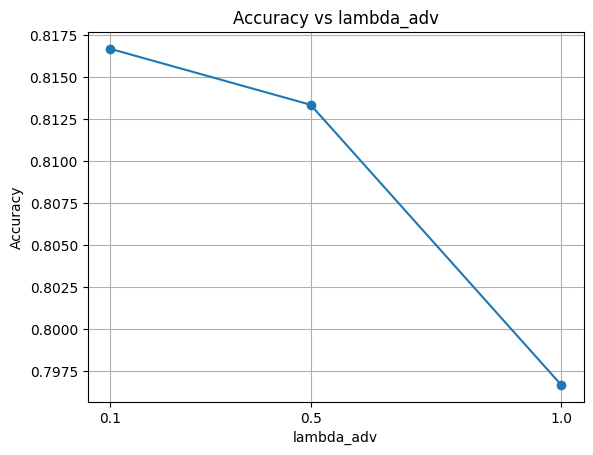

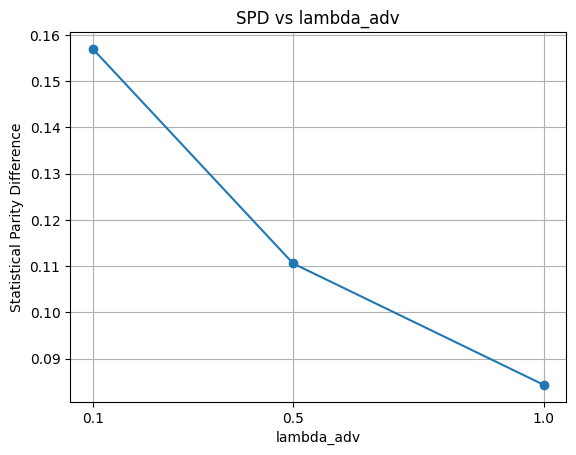

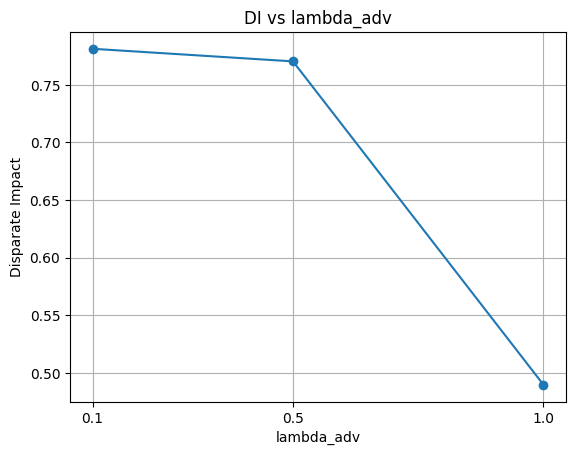

In [11]:
lams = results['lambda_adv']
acc = results['accuracy']
spd_vals = [spd[0][1] for spd in results['SPD']]
di_vals  = [di[0][1]  for di  in results['DI']]

di_dev = [abs(1.0 - v) for v in di_vals]

df_res = pd.DataFrame({
    'lambda_adv': lams,
    'accuracy': acc,
    'SPD': spd_vals,
    'DI': di_dev
})
print(df_res)

plt.figure()
plt.plot(df_res['lambda_adv'], df_res['accuracy'], marker='o')
plt.xlabel('lambda_adv')
plt.ylabel('Accuracy')
plt.title('Accuracy vs lambda_adv')
plt.xticks(lams)
plt.grid(True)

plt.figure()
plt.plot(df_res['lambda_adv'], df_res['SPD'], marker='o')
plt.xlabel('lambda_adv')
plt.ylabel('Statistical Parity Difference')
plt.title('SPD vs lambda_adv')
plt.xticks(lams)
plt.grid(True)

plt.figure()
plt.plot(df_res['lambda_adv'], df_res['DI'], marker='o')
plt.xlabel('lambda_adv')
plt.ylabel('Disparate Impact')
plt.title('DI vs lambda_adv')
plt.xticks(lams)
plt.grid(True)

plt.show()